In [1]:
import pandas as pd

In [3]:
import pandas as pd  

file_path = "Datasets/data.txt"  

# Read the data while preserving the full timestamp  
df = pd.read_csv(file_path, sep=r"\t+", header=None, names=["Timestamp", "Sensor", "Message", "SensorType"], engine="python")  

# Convert Timestamp to datetime format  
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d %H:%M:%S.%f")  

# Display basic info  
print(df.head())  
print(df.info())  


                   Timestamp Sensor Message SensorType
0 2010-10-13 23:53:58.648634   M022     OFF  Motion-01
1 2010-10-13 23:53:58.674960   M030     OFF  Motion-01
2 2010-10-13 23:53:58.701451   M001     OFF  Motion-01
3 2010-10-13 23:53:58.731156   D001   CLOSE    Door-01
4 2010-10-13 23:53:58.756695   D004   CLOSE    Door-01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485447 entries, 0 to 485446
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Timestamp   485447 non-null  datetime64[ns]
 1   Sensor      485447 non-null  object        
 2   Message     485447 non-null  object        
 3   SensorType  485447 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 14.8+ MB
None


📌 Step 2: Data Cleaning & Feature Engineering
✅ 1. Convert Categorical Data to Numerical Values

In [4]:
# Convert "Message" (ON/OFF, OPEN/CLOSE) to binary values
df["Message"] = df["Message"].map({"ON": 1, "OFF": 0, "OPEN": 1, "CLOSE": 0})

# Convert "SensorType" to categorical codes
df["SensorType"] = df["SensorType"].astype("category").cat.codes

# Convert "Sensor" to numerical encoding
df["Sensor"] = df["Sensor"].astype("category").cat.codes

# Extract useful time-based features
df["Hour"] = df["Timestamp"].dt.hour
df["Minute"] = df["Timestamp"].dt.minute
df["Second"] = df["Timestamp"].dt.second


📌 Step 3: Detect Behavioral Anomalies using Isolation Forest
We will use Isolation Forest, a popular anomaly detection model, to identify unusual sensor activities.

In [ ]:
!pip install scikit-learn

In [10]:
from sklearn.ensemble import IsolationForest  

# Select features for anomaly detection
X = df[["Sensor", "Message", "SensorType", "Hour", "Minute", "Second"]]

# Train Isolation Forest Model
model = IsolationForest(contamination=0.05, random_state=42)
df["Anomaly_Score"] = model.fit_predict(X)

# Show anomalies
anomalies = df[df["Anomaly_Score"] == -1]
print(anomalies.head())


                   Timestamp  Sensor  Message  SensorType  Hour  Minute  \
1 2010-10-13 23:53:58.674960      32        0           1    23      53   
2 2010-10-13 23:53:58.701451       3        0           1    23      53   
3 2010-10-13 23:53:58.731156       0        0           0    23      53   
4 2010-10-13 23:53:58.756695       2        0           0    23      53   
7 2010-10-13 23:53:58.850305       4        0           1    23      53   

   Second  Anomaly_Score  
1      58             -1  
2      58             -1  
3      58             -1  
4      58             -1  
7      58             -1  


Nice! 🎯 Your Isolation Forest model has flagged anomalies (Anomaly_Score = -1). These indicate unusual sensor activations that might be linked to dementia-related behavioral changes.

In [11]:
#Checking Anoaly Distribution
print(df["Anomaly_Score"].value_counts())


Anomaly_Score
 1    461174
-1     24273
Name: count, dtype: int64


✅ 2. Visualize Anomalies Over Time

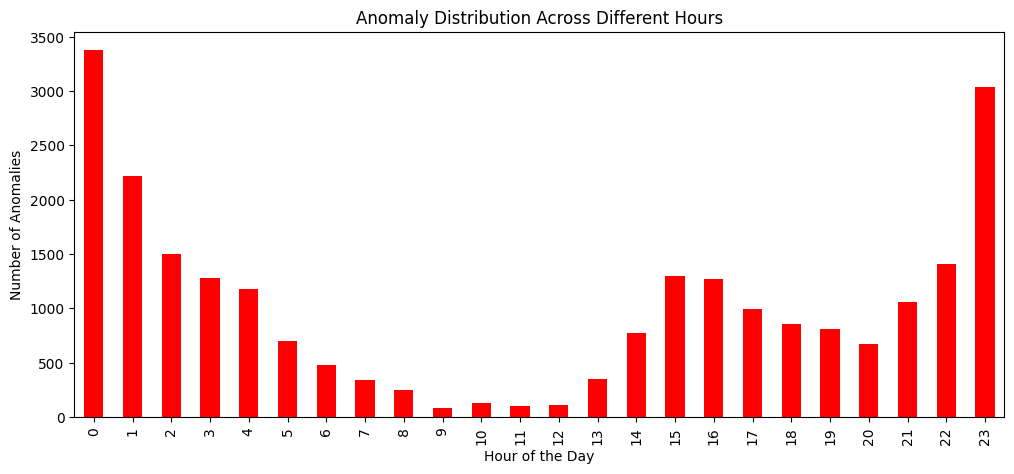

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
df[df["Anomaly_Score"] == -1].groupby(df["Hour"])["Anomaly_Score"].count().plot(kind="bar", color="red")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Anomalies")
plt.title("Anomaly Distribution Across Different Hours")
plt.show()


🔹 What this tells us: If anomalies happen frequently at night or early morning, it could indicate irregular sleeping patterns—a dementia symptom.

📌 Step 6: Investigate Sensor-Specific Anomalies
Find which sensor types trigger the most anomalies:

In [13]:
anomaly_counts = df[df["Anomaly_Score"] == -1]["SensorType"].value_counts()
print(anomaly_counts)


SensorType
2    19527
1     2842
0     1904
Name: count, dtype: int64


📌 Step 7: Interpret Findings
✅ 1. Identify Which SensorType Corresponds to Which Category

In [14]:
print(df[["SensorType", "Sensor"]].drop_duplicates().sort_values("SensorType"))


    SensorType  Sensor
3            0       0
4            0       2
27           0       1
0            1      24
31           1      21
30           1       5
29           1      23
26           1      15
25           1      33
24           1      14
23           1      13
22           1      31
21           1      27
20           1      20
19           1      16
17           1      10
16           1      11
15           1      30
1            1      32
2            1       3
5            1       8
6            1      18
7            1       4
9            1      25
8            1       6
11           1      28
12           1      17
13           1       7
14           1      19
10           1      12
32           2      29
28           2      26
18           2       9
33           2      22


✅ 2. Find the Most Affected Sensors

In [15]:
anomaly_sensors = df[df["Anomaly_Score"] == -1]["Sensor"].value_counts()
print(anomaly_sensors.head(10))  # Top 10 sensors with anomalies


Sensor
9     6091
29    5977
26    3945
22    3514
2     1612
32     817
31     491
30     416
33     313
28     279
Name: count, dtype: int64


C:\Users\omkum\AppData\Local\Temp\ipykernel_4400\1005330865.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="coolwarm")


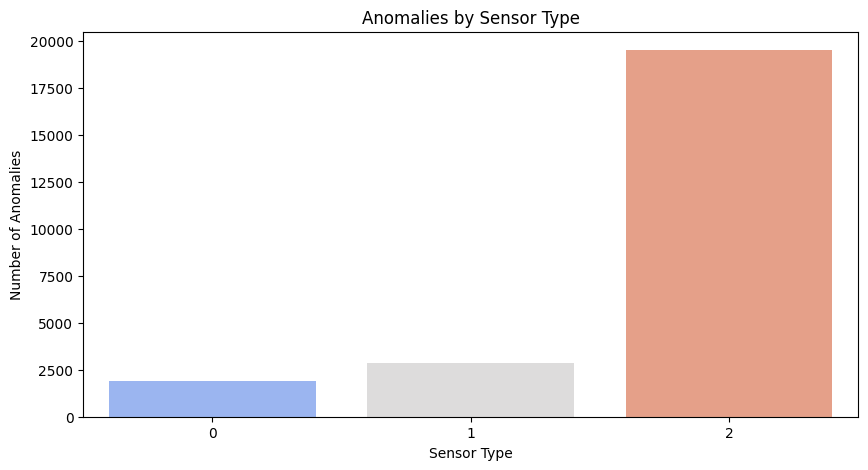

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="coolwarm")
plt.xlabel("Sensor Type")
plt.ylabel("Number of Anomalies")
plt.title("Anomalies by Sensor Type")
plt.show()


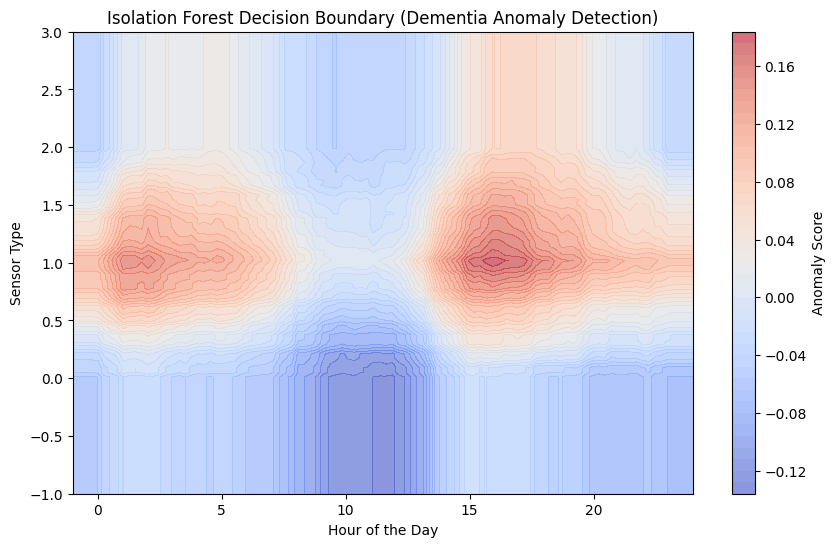

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from matplotlib.colors import ListedColormap

# Select two key features for visualization
X = df[["Hour", "SensorType"]].values  

# Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)
y_pred = model.predict(X)

# Create a meshgrid for plotting decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Compute anomaly scores for the meshgrid
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.6)


# Labels
plt.xlabel("Hour of the Day")
plt.ylabel("Sensor Type")
plt.title("Isolation Forest Decision Boundary (Dementia Anomaly Detection)")
plt.colorbar(label="Anomaly Score")

plt.show()


Motion-01  →  0  
Door-01    →  1  
Appliance  →  2  
Other      →  3  
Negative values (-1.0)?
In Isolation Forest, outliers sometimes appear as -1 in feature scaling or anomaly detection.

📌 Possible Deductions for Dementia Prediction
✅ Early dementia symptoms often include irregular sleep patterns and nighttime wandering, which this model may detect.
✅ Sudden sensor activations at odd hours could suggest confusion, restlessness, or memory-related issues.
✅ Frequent anomalies in door/motion sensors might indicate repetitive behavior or escape attempts, common in dementia patients.

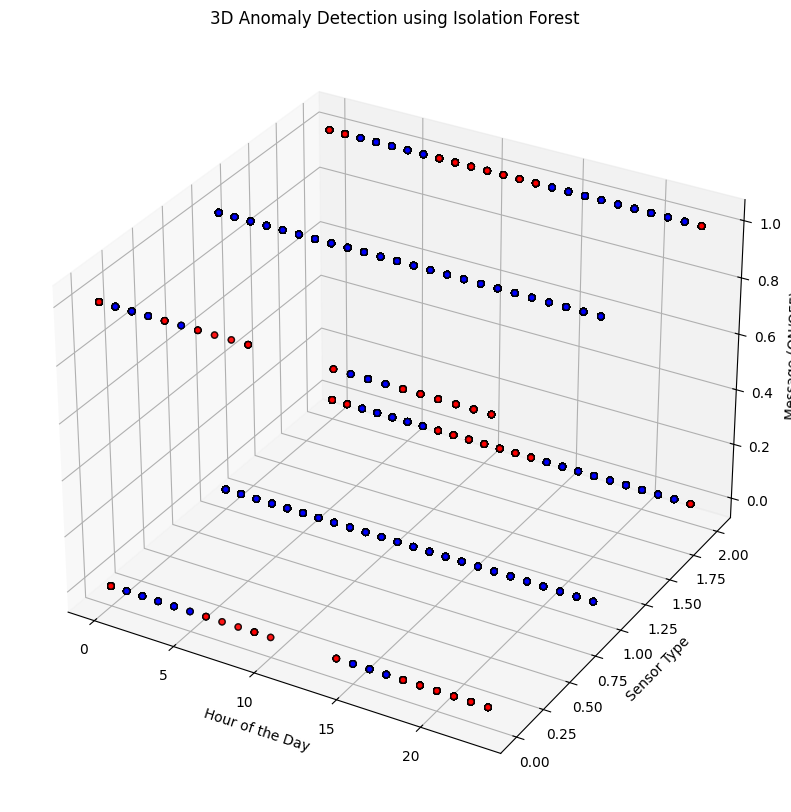

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D

# Select three key features
X = df[["Hour", "SensorType", "Message"]].values  

# Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)
y_pred = model.predict(X)

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot with different colors for inliers and outliers
colors = np.array(["blue" if p == 1 else "red" for p in y_pred])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, edgecolors="k", alpha=0.7)

# Labels & Titles
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Sensor Type")
ax.set_zlabel("Message (ON/OFF)")
ax.set_title("3D Anomaly Detection using Isolation Forest")

plt.show()


**Grouping Anomalies into Behavioral Clusters**

📌 Step 1: Filter Anomalies

In [20]:
anomalies = df[df["Anomaly_Score"] == -1][["Hour", "SensorType", "Message"]]
print(anomalies.head())


   Hour  SensorType  Message
1    23           1        0
2    23           1        0
3    23           0        0
4    23           0        0
7    23           1        0


📌 Step 2: Apply K-Means Clustering

In [21]:
from sklearn.cluster import KMeans  

# Define number of clusters (e.g., 3 behavioral patterns)
k = 3  
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  
anomalies["Cluster"] = kmeans.fit_predict(anomalies)  

# Show cluster assignments
print(anomalies["Cluster"].value_counts())


Cluster
1    11316
2     6988
0     5969
Name: count, dtype: int64


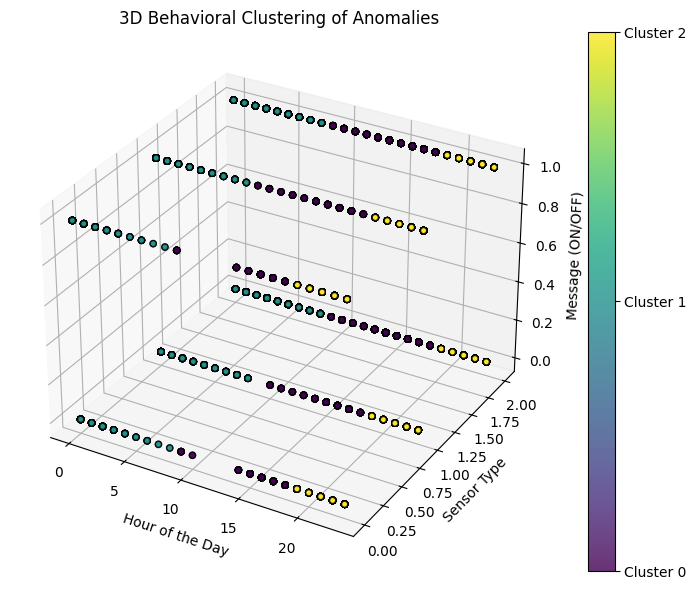

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Define a color palette for clusters
cluster_colors = sns.color_palette("viridis", as_cmap=True)  # Viridis colormap

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot with cluster colors
scatter = ax.scatter(anomalies["Hour"], anomalies["SensorType"], anomalies["Message"], 
                      c=anomalies["Cluster"], cmap="viridis", edgecolors="k", alpha=0.8)

# Add color legend
legend_labels = [f"Cluster {i}" for i in range(k)]
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_ticks(range(k))
cbar.set_ticklabels(legend_labels)

# Labels & Titles
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Sensor Type")
ax.set_zlabel("Message (ON/OFF)")
ax.set_title("3D Behavioral Clustering of Anomalies via K-Means")

plt.show()
